In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

#### Общая постановка задачи

Уравнение теплопроводности:  
$$
c \rho \frac{\partial T}{\partial t} = \frac{\partial}{\partial X} \left(\lambda(X, t) \frac{\partial T}{\partial X}\right) + Q(X, t)
$$
С начальными условиями:  
$$
T(X, 0) = T_0
$$
И с граничными условиями:
$$
T(0, t) = T_1,
$$

$$
T(l, t) = T_2
$$

#### Обезразмеренная постановка задачи

Рассмотрим уравнение теплопроводности в безразмерных координатах:  

$$
\frac{\partial u}{\partial \tau} = \frac{\partial}{\partial x} \left(a(x, \tau) \frac{\partial u}{\partial x}\right) + q(x, \tau)
$$

x - безразмерная координата вдоль стежня 
$$
x = \frac{X}{l}
$$
где $l$ - длина стержня.  
$$
a = \frac{\lambda}{c \rho}
$$
температура же обезразмеривается с помощью граничных условий
$$
u = \frac{T(X, t) - T_0}{T_1 - T_0}
$$

#### Доп. условие задачи

Под условием на $a(x, \tau)$ подразумеваются два случая:  
1. случаное непрерывное распределение,  
2. линейная зависимость от температуры

Первый случай задается из рандомного распределения:

In [193]:
#coeffA = [random.random() for _ in range(len(x_j))]

Для удобства используется распределение от 0 до 1, чтобы не оказывать влияния на число Куранта.  
При необходимости можно другого распределения для явного метода число Куранта будет зависеть от max значения коэффициента $a(x, \tau)$:

$$
max(a(x, \tau)) \frac{\tau}{h^2} < \frac{1}{2}
$$

Для линейной зависимости от температуры используется следующее соотношение:

In [2]:
#coeffA = 0.5 * u[i] + 0.001

#### Варианты начальных и граничных условий, а также, источников.

##### 1)

Начальные условия:  
$$
T(x, 0) = const_1
$$
Граничные условия:
$$
T(0, t) = const_2,
$$

$$
T(x_{max}, t) = const_3
$$
Источники отсутствуют

Задается внутри функций:

In [3]:
#u[0] = initialCond
#u[:, 0] = 0
#u[:, -1] = 1

##### 2)

Начальные условия:  
$$
T(x, 0) = const_1
$$
Граничные условия:
$$
T(0, t) = f(t),
$$

где $f(t)$  - ступенчатая функция 
$$
T(x_{max}, t) = const_3
$$
  
Источники отсутствуют

Задается внутри функций:

In [4]:
#u[0] = initialCond
#u[:, 0] = 0 + coeffDeltaT * tau * i 
#u[:, -1] = 1

Где *coeffDeltaT*, во избежание проблем, лучше только уменьшать $->$ делать меньше 1.  
*coeffDeltaT* по умолчанию (для условий 1, 3 и 4) равен 0.

##### 3)

Начальные условия:  
$$
T(x, 0) = const_1
$$
Граничные условия:
$$
T(0, t) = const_2,
$$

$$
T(x_{max}, t) = const_3
$$
Источники:
$$
Q(x_1, t) = const_4
$$

Задается внутри функций:

In [5]:
#u[0] = initialCond
#u[:, 0] = 0
#u[:, -1] = 1
#Q[:, xwithQ] = constQ

При *constQ = -1* источники выключены. Для включения источников нужно передать в переменную *constQ* значение $const_4$.

##### 4)

Начальные условия:  
$$
T(x, 0) = const_1
$$
Граничные условия:
$$
T(0, t) = const_2,
$$

$$
T(x_{max}, t) = const_3
$$
Источники:
$$
Q(x_1, t) = g(t)
$$
$g(t)$ аналогична $f(t)$

Задается внутри функций:

In [6]:
#u[0] = initialCond
#u[:, 0] = 0
#u[:, -1] = 1
#Q[:, xwithQ] = 0 + coeffDeltaQ * tau * i

Поверка на условие в источниках осуществляется по переменной *xwithQ*.

Функция для проверки выполнения условия Куранта.

In [7]:
def CourantCheck(tau, h):
    if (tau / h**2) >= 0.5:
        print("Change tau! Or suffer from hopelessness.")
        return False

In [16]:
tau = 1 / 100000
h = 1 / 100
x_j = np.arange(0, 1 + h, h)
t_i = np.arange(0, 1 + tau, tau)
u = np.zeros([len(t_i), len(x_j)])
Q = np.zeros([len(t_i), len(x_j)])

Явная разностная схема:

$$
u_k^{n + 1} = u_k^n + \tau q_k^n + \frac{\tau}{h} \left(a_{k + 1/2}^n \frac{u_{k + 1}^n - u_k^n}{h} - a_{k - 1/2}^n \frac{u_k^n - u_{k - 1}^n}{h}\right)
$$

где 
$$
a_{k + 1/2}^n = \frac{a_{k + 1}^n + a_k^n}{2}
$$

Функция, вычисляющая явно значение в безразмерных координатах.

In [36]:
def explicitSolver(initialCond, stepsByTime = 100000, stepsByX = 100,  
                   coeffDeltaT = 0, coeffDeltaQ = 0, xWithQ = -1, constQ = -1,
                   temperatureDependence = False):
    """Явное решение уравнения теплопроводности
    
    :initialCond: начальное значение температуры, лучше от 0 до 1
    :stepsByTime: количество шагов по времени, по умолчанию 100000
    :stepsByX: количество шагов по x, по умочанию 100
    :coeffDeltaT: приращение по температуре для случая 2 граничных условий
    :xWithQ: элемент x_1 массива, в котором различается значение источника, если равен -1, то точечный источник выключен
    :constQ: значение точечного источника для случая 3 граничных условий
    :temperatureDependence: зависимость от температуры коэффициента а, по умолчанию отсутствует
    """
      
    tau = 1 / stepsByTime
    h = 1 / stepsByX
    
    message = CourantCheck(tau, h)
    if message == False:
        return 0, 0
    
    x_j = np.arange(0, 1 + h, h)
    t_i = np.arange(0, 1 + tau, tau)
    u = np.zeros([len(t_i), len(x_j)])
    Q = np.zeros([len(t_i), len(x_j)])
    
    if constQ != -1: # проверка, что источники отсутствуют
        Q[:, xWithQ] = constQ
    
    coeffA = [random.random() for _ in range(len(x_j))]
    
    for i in range(len(t_i)):
        if i == 0:
            u[0] = initialCond
        else:
            for j in range(len(x_j)):
                if j == 0:
                    u[i, j] = 0 + coeffDeltaT * tau * i 
                elif j == len(x_j) - 1:
                    u[i, j] = 1
                else:
                    if xWithQ != -1 and j == xWithQ:
                        Q[i, j] = 0 + coeffDeltaQ * tau * i
                    
                    right = 0.5 * (coeffA[j + 1] + coeffA[j]) * (u[i - 1, j + 1] - u[i - 1, j])
                    left = 0.5 * (coeffA[j] + coeffA[j - 1]) * (u[i - 1, j] - u[i - 1, j - 1])
                    
                    u[i][j] = u[i - 1][j] + tau * Q[i - 1][j] + (tau / h**2) * (right - left)
        
        if temperatureDependence:
            coeffA = 0.5 * u[i] + 0.001
    
    return u, x_j

In [37]:
u, x_j = explicitSolver(0.1)

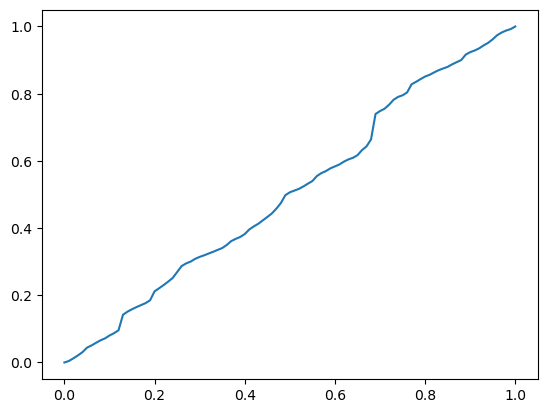

In [38]:
plt.plot(x_j, u[-1])
plt.show()

Функция, вычисляющая неявно значение в безразмерных координатах.

In [27]:
def implicitSolver(initialCond, stepsByTime = 100000, stepsByX = 100,  
                   coeffDeltaT = 0, coeffDeltaQ = 0, xWithQ = -1, constQ = -1,
                   temperatureDependence = False):
    
    tau = 1 / stepsByTime
    h = 1 / stepsByX
    
    x_j = np.arange(0, 1 + h, h) # x - ksi - обезразмеренная 
    t_i = np.arange(0, 1 + tau, tau)
    u = np.zeros([len(t_i), len(x_j)])
    Q = np.zeros([len(t_i), len(x_j)])
    
    if constQ != -1:
        Q[:, xWithQ] = constQ
    
    coeffA = [random.random() for _ in range(len(x_j))]
    
    for i in range(len(t_i)):
    
        alpha = np.zeros(len(x_j))
        beta = np.zeros(len(x_j))
    
        if i == 0:
            u[0] = initialCond
        
        else:
            for j in range(len(x_j)):
                if j == 0:
                    u[i, j] = 0 + coeffDeltaT * tau * i 
                
                    beta[0] = u[i, j]  
                    alpha[0] = 0
                
                elif j == len(x_j) - 1:
                    u[i, j] = 1
                else:
                    
                    if xWithQ != -1 and j == xWithQ:
                        Q[i, j] = 0 + coeffDeltaQ * tau * i
                    
                    A = (tau / h**2) * 0.5 * (coeffA[j] + coeffA[j - 1])
                    B = - 1 - (tau / h**2) * (0.5 * (coeffA[j + 1] + coeffA[j]) + 0.5 * (coeffA[j] + coeffA[j - 1]))
                    C = (tau / h**2) * 0.5 * (coeffA[j + 1] + coeffA[j])
                    F = - tau * Q[i - 1, j] - u[i - 1, j]
                
                    alpha[j] = - C / (A * alpha[j - 1] + B)
                    beta[j] = (F - A * beta[j - 1]) / (A * alpha[j - 1] + B)
                
            for j in range(len(x_j) - 1, 0, -1):
                u[i, j - 1] = alpha[j - 1] * u[i, j] + beta[j - 1]
        
        if temperatureDependence:
            coeffA = 0.5 * u[i] + 0.001
            
    return u, x_j

In [28]:
u, x_j = implicitSolver(0.4)

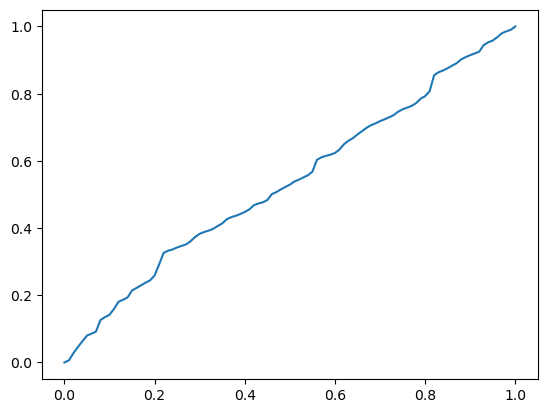

In [192]:
plt.plot(x_j, u[-1])
plt.show()

In [ ]:
Тут должна быть функция, объединяющая эти две